# Empirical studyとResearch Proposal

||概要|
|---|---|
|更新日|2020-03-04 Wednesday|
|目的|research designの重要性の確認|

## Why research design is the centerpiece of empirical research?

以前は、outcome variable, Yとvariable of interest, Xを定め、YとXの回帰分析をするという実証研究が主流で、そこではXのvariationがどのようなメカニズムで発生したのかにはフォーカスしていなかった。現在は、

- variationはどのように発生するのか？
- confounding factorはなにで、どのようにすればその影響を除外して、興味のあるパラメーターが推定できるのか？

を考えて実証研究をする。

次のようなモデルを考える。

- $Y_i$: outcome
- $T_i$: treatment
- $\epsilon_i$: error term

$$
y_i = \alpha + \beta T_i + \epsilon_i
$$

treatmentは以下のselectionに基づくとする

$$
\begin{aligned}
T_i &= \alpha_T + \beta_T X_i + \eta_i
\end{aligned}
$$

Treatment may not be random, that is,

$$
\begin{aligned}
cov(X_i, \epsilon_i) &\neq 0\\
cov(\eta_i, \epsilon_i) &\neq 0
\end{aligned}
$$

#### Traditional approach

$$
y_i = \alpha + \beta T_i + \gamma X_i + \epsilon_i
$$

- そのほかにもpropensity-score weightingやmatchingで推定する
- これらの方法はなぜ$T_i$のvariationが生まれるのか説明できておらず、内生性の問題が残る

例えば、よく労働経済で用いられるreturn to schoolingと教育年数が異なるtwinの比較では、twinは家庭環境が似ているので、potential outcomeは差がない。よって最終的なoutcomeが異なり、教育年数も異なるならば、それはreturn to schoolingのパラメーターとして考えて良い、という説明がある。

しかしながら、この例ではなぜ結局、双子の間で教育年数が異なったのかを説明し切れておらず、それが説明できない限り推定量にはバイアスの恐れが残ると考えられる。

- 双子の間での性格の差
- 小学校の時の担当教育の差に起因する教育へのモチベーションの差

これらの要因はselection modelでの$\eta_i$に反映されてしまうし、$cov(\eta_i, \epsilon_i) \neq 0$は十分考えられる。

だからこそ、research designの段階でこのような要素を考慮した上で、何を推定するのか、それはresearch questionとどのような関係があるのか、dataは何か、dataのvariationはどのようなメカニズムで発生しているのか？、推定量は何か？を考える必要がある。


## simulationで上の問題を示す

import

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import statsmodels.api as sm
from patsy import dmatrices
import random

In [2]:
random.seed(10101)

In [3]:
### sample size
N = 1000

### params
alpha = 10
beta = 5
alpha_t = 6
gamma = 3

### residual
cov = [[1,0.9], [0.9, 1]]
eps, eta = np.random.multivariate_normal([0,0],cov, N).T

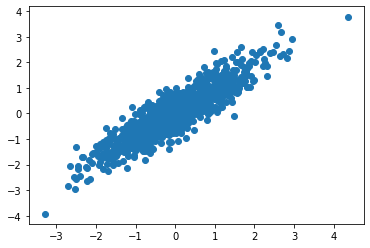

In [4]:
plt.scatter(eps, eta);

In [5]:
### variables
X = np.random.uniform(0, 3, N)
T = alpha_t + gamma*X + eta

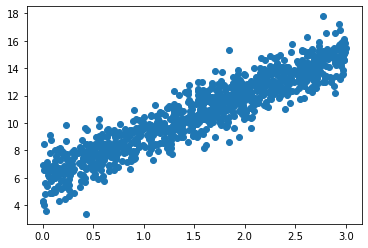

In [6]:
plt.scatter(X, T);

In [7]:
### outcome
y = alpha + beta*T + 5*eps

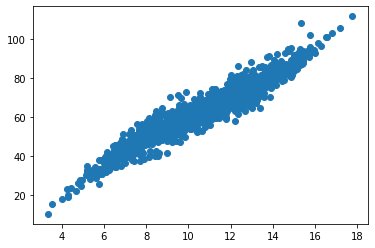

In [8]:
plt.scatter(T, y);

naiveなregression

In [9]:
T_naive = sm.add_constant(T)
model = sm.OLS(y, T_naive)
res = model.fit()
summary = res.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.915
Model:                            OLS   Adj. R-squared:                  0.915
Method:                 Least Squares   F-statistic:                 1.075e+04
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:23:07   Log-Likelihood:                -2949.7
No. Observations:                1000   AIC:                             5903.
Df Residuals:                     998   BIC:                             5913.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.5797      0.593      6.032      0.0

In [10]:
### Multiple OLS
X.shape = 1000, 1
T_multi = np.hstack([T_naive, X])

In [11]:
model = sm.OLS(y, T_multi)
res = model.fit()
summary = res.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                 2.607e+04
Date:                Wed, 04 Mar 2020   Prob (F-statistic):               0.00
Time:                        14:23:07   Log-Likelihood:                -2194.7
No. Observations:                1000   AIC:                             4395.
Df Residuals:                     997   BIC:                             4410.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -17.4209      0.451    -38.633      0.0

In [12]:
y_hat = res.params[0] + res.params[1]*T

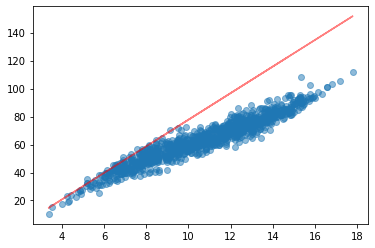

In [13]:
plt.scatter(T, y, alpha =0.5)
plt.plot(T, y_hat, alpha = 0.5, color = 'r')

推定されたパラメーターはupward biased